In [69]:
import pyphen
import string
import re
import collections

import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Flatten
import keras

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
hypher = pyphen.Pyphen(lang='hu_HU')

In [3]:
def hyph_class(word, hypher=pyphen.Pyphen(lang='hu_HU'), aslist=False):
    """Hyphenating classification of the characters in the word. {B(egin),M(iddle),E(nd),S(ingle)}"""
    if(len(word)==0):
        raise IndexError("0 length word")
    ret = list('M' * len(word))
    ret[0]='B'
    ret[-1]='E'
    for i in hypher.positions(word):
        ret[i]='B'
        if(ret[i-1]=='B'):
            ret[i-1]='S'
        else:
            ret[i-1]='E'
    if(aslist):
        return ret
    return "".join(ret)
def same_char_num(word, hypher=pyphen.Pyphen(lang='hu_HU')):
    """Return true if the hyphenated word has as many chars as the original"""
    return len(hypher.inserted(word))==len(word)+len(hypher.positions(word))
def cleaning(data):
    """Text cleaning:
        lower the letters
        punctuation, digits ellimination"""
    formated_data = data.lower()
    formated_data = re.sub('['+string.punctuation+']','',formated_data)
    formated_data = re.sub('['+string.digits+']','',formated_data)
    return formated_data

In [4]:
counter_hu_data = collections.Counter()
word_list = []
c_all = 0
c_same_char_num = 0
with open('web2.2-freq-sorted.txt','r',errors='ignore',encoding='latin2') as f:
    i = 0
    for line in f:
        i = i+1
        words = line.split()
        if len(words)>1:
            if(words[1].isdigit()):
                counter_hu_data[cleaning(words[0])]+=int(words[1])
        if i>100000:
            break
for words in counter_hu_data.most_common():
    c_all+=1
    next_word = words[0]
    if(len(next_word)!=0 and same_char_num(next_word)):
        c_same_char_num+=1
        word_list.append([next_word,hyph_class(next_word)])

In [5]:
print(c_same_char_num,c_all,c_same_char_num/c_all)

82181 83286 0.9867324640395745


In [6]:
print(word_list[100:200])

[['ember', 'BEBME'], ['ezek', 'BMME'], ['tovább', 'BEBMME'], ['vagyok', 'BEBMME'], ['ma', 'BE'], ['miatt', 'BEBME'], ['this', 'BMME'], ['mellett', 'BMEBMME'], ['vannak', 'BMEBME'], ['by', 'BE'], ['alapján', 'BMMEBME'], ['lenne', 'BMEBE'], ['with', 'BMME'], ['that', 'BMME'], ['tehát', 'BEBME'], ['te', 'BE'], ['it', 'BE'], ['ben', 'BME'], ['egész', 'BMMME'], ['néhány', 'BEBMME'], ['milyen', 'BEBMME'], ['át', 'BE'], ['nekem', 'BEBME'], ['előtt', 'BMMME'], ['ezzel', 'BEBME'], ['mivel', 'BEBME'], ['ezen', 'BMME'], ['nélkül', 'BMEBME'], ['lett', 'BMME'], ['stb', 'BME'], ['you', 'BME'], ['viszont', 'BEBMMME'], ['év', 'BE'], ['teljes', 'BMEBME'], ['erre', 'BEBE'], ['hiszen', 'BEBMME'], ['másik', 'BEBME'], ['ebben', 'BEBME'], ['mind', 'BMME'], ['der', 'BME'], ['három', 'BEBME'], ['talán', 'BEBME'], ['valami', 'BEBEBE'], ['die', 'BME'], ['bár', 'BME'], ['are', 'BME'], ['legyen', 'BEBMME'], ['tudom', 'BEBME'], ['from', 'BMME'], ['inkább', 'BEBMME'], ['során', 'BEBME'], ['például', 'BMEBEBE'], ['r

In [7]:
#onehot: {'B','M','E','S'}
def one_hot_encode(char,dictionary='BMES'):
    ret = [0]*len(dictionary)
    if char in dictionary:
        ret[dictionary.find(char)]=1
        return ret
    raise ValueError('Value out of dictionary range'+char)

In [92]:
hun_chars='aábcdeéfghiíjklmnoóöőpqrstuúüűvwxyz'+'.'
def generate_network_data(data, ret_input = [],ret_output=[],length = 2, start_char='.', chars=hun_chars):
    """from [word,hyph_class(word) to length-long input-output data"""
    word = data[0]
    word_plus = start_char*(length-1)+word
    hyph_word = data[1]
    for i in range(0,len(word)):
        input_next_iter = []
        for c in word_plus[i:i+length]:
            input_next_iter.append(one_hot_encode(c,chars))
        output_next_iter = one_hot_encode(hyph_word[i])
        ret_input.append(input_next_iter)
        ret_output.append(output_next_iter)

In [30]:
wc_in=[]
wc_out=[]

generate_network_data(['alma','BEBE'],wc_in, wc_out)
print(wc_in[0],wc_out[0])

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]] [1, 0, 0, 0]


In [89]:
window_length = 3

In [90]:
data_in = []
data_out = []
wrong_word = 0
for word in word_list:
    try:
        generate_network_data(word,data_in,data_out,window_length)
    except ValueError:
        wrong_word+=1
print('Data len: ',len(data_in))
print('Wrong words: ',wrong_word)

Data len:  695849
Wrong words:  640


In [91]:
valid_rate=0.2
test_rate=0.1

train_input = []
train_target = []
valid_input = []
valid_target = []
tests_input = []
tests_target = []
for i in range(len(data_in)):
    ran = np.random.random()
    if ran-valid_rate<0:
        valid_input.append(data_in[i])
        valid_target.append(data_out[i])
    elif ran-valid_rate-test_rate<0:
        tests_input.append(data_in[i])
        tests_target.append(data_out[i])
    else:
        train_input.append(data_in[i])
        train_target.append(data_out[i])
train_input = np.array(train_input,dtype='float32')
train_target= np.array(train_target,dtype='float32')
valid_input = np.array(valid_input,dtype='float32')
valid_target= np.array(valid_target,dtype='float32')
tests_input = np.array(tests_input,dtype='float32')
tests_target= np.array(tests_target,dtype='float32')
print('Training data size:',len(train_input))
print('Validation data size:',len(valid_input))
print('Test data size:',len(tests_input))

Training data size: 487064
Validation data size: 139046
Test data size: 69739


In [122]:
model = Sequential()
model.add(Dense(input_shape=(window_length,len(hun_chars)), units=10, name='input_layer',activation='relu'))
model.add(Dense(units=10, activation='relu'))
model.add(Flatten())
model.add(Dense(4,name='output_layer', activation='softmax'))

In [123]:
model.compile(loss='categorical_crossentropy',optimizer='sgd')

In [124]:
history = model.fit(train_input,train_target, epochs=50, batch_size=1024, 
                    validation_data=(valid_input,valid_target), verbose=0.1,
                   shuffle= True)

Train on 487064 samples, validate on 139046 samples
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


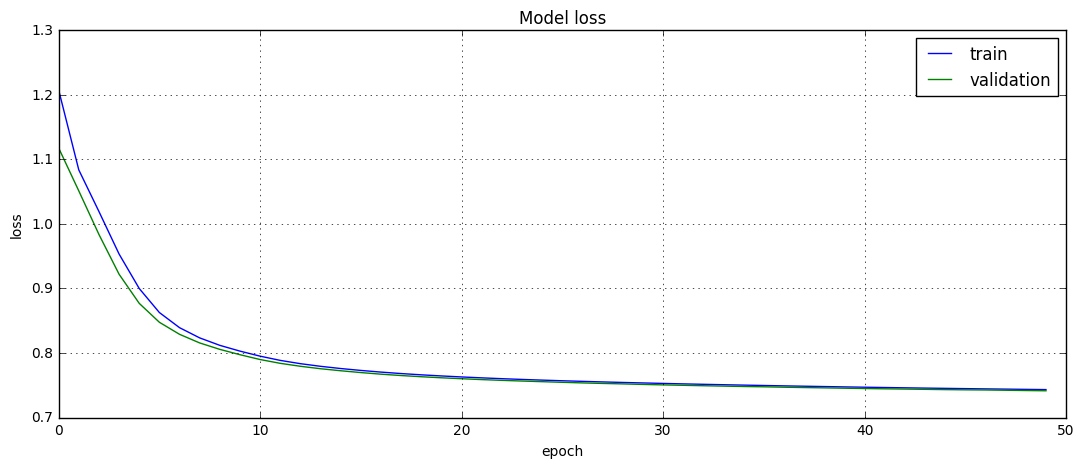

In [126]:
# summarize history for loss
plt.figure(figsize=(13, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.grid()
plt.show()